#Импорты библиотек

In [1]:
try:
  import numpy as np
  import random
except:
  !pip install numpy
  import numpy as np
  import random

In [2]:
try:
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_score
  from sklearn.datasets import make_blobs
  from sklearn.metrics import davies_bouldin_score
except:
  !pip install sklearn
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_score
  from sklearn.datasets import make_blobs
  from sklearn.metrics import davies_bouldin_score

In [3]:
try:
  from skopt import gp_minimize
except:
  !pip install scikit-optimize
  from skopt import gp_minimize

In [4]:
try:
  import matplotlib.pyplot as plt
except:
  !pip install matplotlib
  import matplotlib.pyplot as plt

In [5]:
import time
import warnings
warnings.filterwarnings('ignore')

#Класс Silhouette

In [6]:
class Silhouette(object):
 
    def __init__(self, data, n_init_points = 5, initial_generator = 'sobol', 
                 acq_function = 'LCB', kappa = 2, noise = 'gaussian', 
                 left_border = 2, right_border = 100, n_calls = 11, 
                 dispersion = 2, random_state = 2022):
        self.data = data
        self.n_init_points = n_init_points
        self.initial_generator = initial_generator
        self.acq_function = acq_function
        self.kappa = kappa
        self.noise = noise
        self.left_border = left_border
        self.right_border = right_border
        self.n_calls = n_calls
        self.dispersion = dispersion
        self.random_state = random_state

    def score_function(self, n):
      clusterer = KMeans(n_clusters = n[0], random_state = self.random_state)
      preds = clusterer.fit_predict(np.array(self.data))
      return 1 - silhouette_score(self.data, preds)

# Класс Davies Bouldin

In [7]:
class DaviesBouldin(object):
 
    def __init__(self, data, n_init_points = 6, initial_generator = 'sobol', 
                 acq_function = 'LCB', kappa = 3, noise = 'gaussian', 
                 left_border = 2, right_border = 100, n_calls = 14, 
                 dispersion = 2, kMeansRandomState = 2022):
        self.data = data
        self.n_init_points = n_init_points
        self.initial_generator = initial_generator
        self.acq_function = acq_function
        self.kappa = kappa
        self.noise = noise
        self.left_border = left_border
        self.right_border = right_border
        self.n_calls = n_calls
        self.dispersion = dispersion
        self.random_state = random_state

    def score_function(self, n):
      clusterer = KMeans(n_clusters = n[0], random_state = self.random_state)
      preds = clusterer.fit_predict(np.array(self.data))
      return davies_bouldin_score(self.data, preds)

#Класс BayesKMeans

In [108]:
class BayesKMeans(object):
 
    def __init__(self, data):
        self.data = data
        self.silhouette = Silhouette(data)
        self.daviesBouldin = DaviesBouldin(data)
        self.x_iters = None
        self.func_vals = None
        self.foundK = None
        if len(data) <= 4000:
          self.methodName = 'silhouette'
          self.method = self.silhouette
        else:
          self.methodName = 'daviesBouldin'
          self.method = self.daviesBouldin

    def findK(self):
      self.__bayesian_optimization()
      
    def getK(self):
      return self.foundK

    def showData(self):
      plt.scatter(self.data[:, 0], self.data[:, 1])
      plt.show()

    def showColoredData(self):
      clusterer = KMeans(n_clusters = self.foundK, random_state = self.method.kMeansRandomState)
      preds = clusterer.fit_predict(np.array(self.data))
      plt.scatter(self.data[:, 0], self.data[:, 1], c=preds)
      plt.show()  

    def showBayesianPlot(self, line = False):
      d = {}
      for i in range(len(self.x_iters)):
        d[self.x_iters[i]] = self.func_vals[i]
      x_asc = sorted(self.x_iters)
      y_asc = []
      for x in x_asc:
        y_asc.append(d[x])
      if line:
        plt.plot(x_asc, y_asc, label=self.methodName)

      plt.scatter(x_asc, y_asc, label=self.methodName, marker='x')
      plt.scatter(self.foundK, d[self.foundK], c='red', marker='+', s=10, label='Target = ' + str(self.foundK))
      plt.xlabel('n_clusters')  
      plt.ylabel('Score')
      plt.legend()
      plt.show()

    def chooseFunction(self, optimizedFunction):
      if optimizedFunction == 'silhouette':
          self.method = self.silhouette
      elif optimizedFunction == 'daviesBouldin':
          self.method = self.daviesBouldin



    def __bayesian_optimization(self):
      result = gp_minimize(
                  self.method.score_function,
                  [[self.method.left_border, self.method.right_border]],
                  acq_func = self.method.acq_function,
                  n_calls = self.method.n_calls,   
                  n_initial_points = self.method.n_init_points,
                  initial_point_generator = self.method.initial_generator,
                  kappa = self.method.kappa,
                  n_points = self.method.right_border - self.method.left_border + 1,   # Так как поиск происходит только по целым значениям, имеет смысл ограничить число точек
                  noise = self.method.noise
                           )
      x_it = []
      for x in result.x_iters:
        x_it.append(x[0])
      self.x_iters = x_it
      self.func_vals = result.func_vals
      self.foundK = result.x[0]
      min_function_value = result.fun

      for d in range(max(self.foundK - self.method.dispersion, 2), self.foundK + self.method.dispersion + 1):
        if d not in self.x_iters:
          self.x_iters.append(d)
          self.func_vals = np.append(self.func_vals, self.method.score_function([d]))
          if self.func_vals[-1] < min_function_value:
            min_function_value = self.func_vals[-1]
            self.foundK = d

# Тестирование

In [142]:
data = make_blobs(n_samples=5000, n_features=2, centers=32, cluster_std=3, center_box=(-300, 300))
data = data[0]

In [143]:
bayesKMeans = BayesKMeans(data)

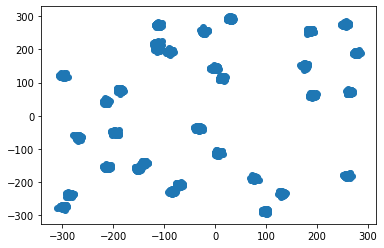

In [144]:
bayesKMeans.showData()

In [138]:
bayesKMeans.chooseFunction('silhouette')

In [145]:
start = time.time()
bayesKMeans.findK()
print(time.time() - start)

15.558974266052246


In [140]:
bayesKMeans.getK()

29

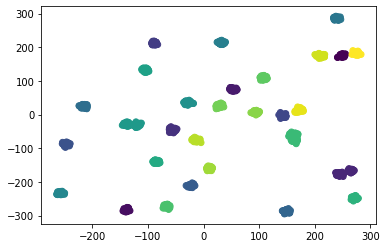

In [92]:
bayesKMeans.showColoredData()

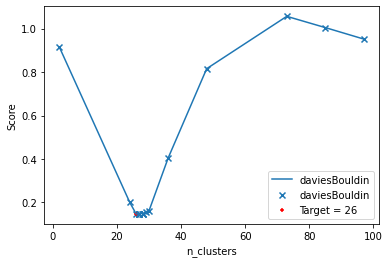

In [146]:
bayesKMeans.showBayesianPlot(line = True)